# now that we have subcortical niftis for all subjects, let's create some masked versions

In [104]:
from __future__ import division
import os
import nibabel as nb
import numpy as np
out_dir = '/home/shared/2018/visual/hcp_cerebellum/'
pkg_dir = '/home/shared/2018/visual/HCP7TFIXED/'


import h5py

import matplotlib.pyplot as pl
%matplotlib inline

In [29]:

dims = {
    'ang':0,
    'ecc':1,
    'gain':2,
    'meanvol':3,
    'r2':4,
    'rfsize':5
}


In [32]:
def gmm_threshold(data,n_components=2,maxrange=100):

    from sklearn.mixture import GMM

    # fit gaussian mixture model to define r2 threshold
    gmm = GMM(n_components = n_components)
    gmm = gmm.fit(np.expand_dims(data,1))

    x = np.linspace(0,maxrange,10000)
    logprob, responsibilities = gmm.score_samples(np.expand_dims(x,1))

    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    order = np.argsort([np.argmax(p) for p in pdf_individual.T])

    # find border between first and second gauss
    thresh = x[np.where(pdf_individual[:,order[1]]>pdf_individual[:,order[0]])[0]][0]

    return thresh

In [157]:
def determine_best_subjects(method,n=10):
    
    """
    this function returns for each subject their rank determined by different methods:
    
    """
    
    
    if method == 'wang_v123':
        
        '''
        this method looks at explained variance in v123 wang atlas to determine best subjects
    
        '''
        
        # determine best subjects based on v123
        with h5py.File(os.path.join(out_dir,'atlas.mat'), 'r') as mat:
            v123mask = np.ravel(mat['wang2015'].value==2)
            for roi in [3,4,5,6,7]:
                v123mask += np.ravel(mat['wang2015'].value==roi)

        all_mean_r2 = []
        for sj in range(181):      
            all_mean_r2.append(np.nanmedian(allresults[0,sj,dims['r2'],v123mask]))

        print all_mean_r2[best_subjects:10]

#         print 'best subjects based on V123 pRF explained variance: %s'%best_subjects

    elif method == 'wang_all':
        
        '''
        this method looks at explained variance in v123 wang atlas to determine best subjects
    
        '''
        
        # determine best subjects based on v123
        with h5py.File(os.path.join(out_dir,'atlas.mat'), 'r') as mat:
            wangmask = np.ravel(mat['wang2015'].value>0)

        all_mean_r2 = []
        for sj in range(181):      
            all_mean_r2.append(np.nanmedian(allresults[0,sj,dims['r2'],wangmask]))
            
#         print np.argsort(all_mean_r2)+1

        best_subjects = np.argsort(all_mean_r2)[::-1][:n]

#         print 'best subjects based on V123 pRF explained variance: %s'%best_subjects
        
        
    elif method == 'cerebellum':
        
        '''
        this method looks at explained variance in cerebellum to determine best subjects
    
        '''
        
        # load cerebellum_mask from the cerebellum atlas
        fncer = '/home/vanes/bin/fsl/data/atlases/Cerebellum/Cerebellum-MNIfnirt-maxprob-thr50-2mm.nii.gz'
        cerimg = nb.load(fncer)
        cdata = cerimg.get_data()
        cmask = (cdata!=0)

        # save cmask to check
        cmaskimg=nb.Nifti1Image(cmask,affine=cerimg.affine,header=cerimg.header)
        nb.save(cmaskimg,os.path.join(out_dir,'cmask.nii'))

        all_mean_r2 = []
        for sj in range(181):      

            # load the prf results nifti
            fn = os.path.join(out_dir,'all_subjects','prfresults_subject_%d.dscalar_data_sub.nii'%sj)
            img = nb.load(fn)
            data = img.get_data()

            # mask r2s with cerebellum mask:
            r2s = np.ravel(data[cmask.astype(bool),dims['r2']])

            all_mean_r2.append(np.nanmedian(r2s))

        best_subjects = np.argsort(all_mean_r2)[::-1][:n]

        print 'best subjects based on cerebellum pRF explained variance: %s'%best_subjects     
        
    elif method == 'cerebellum_gmm':
        
        '''
        this method looks at explained variance in cerebellum to determine best subjects
        In addition to the 'cerebellum' method, this method also separates 'signal' and 'noise' 
        voxel pools by fitting a gaussian mixture model (GMM) to the r2s and only regarding the signal pool
    
        '''
        
        # load cerebellum_mask from the cerebellum atlas
        fncer = '/home/vanes/bin/fsl/data/atlases/Cerebellum/Cerebellum-MNIfnirt-maxprob-thr50-2mm.nii.gz'
        cerimg = nb.load(fncer)
        cdata = cerimg.get_data()
        cmask = (cdata!=0)

        # save cmask to check
        cmaskimg=nb.Nifti1Image(cmask,affine=cerimg.affine,header=cerimg.header)
        nb.save(cmaskimg,os.path.join(out_dir,'cmask.nii'))

        all_mean_r2 = []
        for sj in range(181):      

            # load the prf results nifti
            fn = os.path.join(out_dir,'all_subjects','prfresults_subject_%d.dscalar_data_sub.nii'%sj)
            img = nb.load(fn)
            data = img.get_data()

            # mask r2s with cerebellum mask:
            r2s = np.ravel(data[cmask,dims['r2']])

            thresh = gmm_threshold(r2s,2,100)

            # now combine cerebellum mask with r2 mask
            r2mask = (data[:,:,:,dims['r2']]>thresh)
            mask = r2mask*cmask

            # mask r2s with cerebellum mask:
            r2s = np.ravel(data[mask.astype(bool),dims['r2']])

            all_mean_r2.append(np.nanmedian(r2s))

        best_subjects = np.argsort(all_mean_r2)[::-1][:n]

#         print 'best subjects based on signal voxels in cerebellum %s'%best_subjects  
    
    elif method == 'cerebellum_rois':
        '''
        This method looks at the median r2 within the cerebellum ROI determined on data from the average subject.
        '''
  
        
        roi_fn = os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')
        maskimg = nb.load(roi_fn)
        roimask = (maskimg.get_data()>0)
        
        all_r2 = []
        for sj in range(181):      

            # load the prf results nifti
            fn = os.path.join(out_dir,'all_subjects','prfresults_subject_%d.dscalar_data_sub.nii'%sj)
            img = nb.load(fn)
            data = img.get_data()

            # mask r2s with roi mask:
            r2s = np.ravel(data[roimask,dims['r2']])    
            all_r2.append(np.nanmedian(r2s))

        best_subjects = np.argsort(all_r2)[::-1][:n]

#         print 'best subjects based on median pRF explained variance within cerebellum ROI %s'%best_subjects

    elif method == 'angular_correlation':
        '''
        This method looks at correlation between a subjects pRF angles and the average subject.
        '''
  
        import pycircstat as ps
    
        roi_fn = os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')
        maskimg = nb.load(roi_fn)
        roimask = (maskimg.get_data()>0)
        
        # load the avg prf results nifti
        fn = os.path.join(out_dir,'all_subjects','prfresults_subject_183.dscalar_data_sub.nii')
        img = nb.load(fn)
        data = img.get_data()  
        avg_angles = np.radians(np.ravel(data[roimask,dims['ang']]))


        all_corrs = []
        for sj in range(181):      

            # load the prf results nifti
            fn = os.path.join(out_dir,'all_subjects','prfresults_subject_%d.dscalar_data_sub.nii'%sj)
            img = nb.load(fn)
            data = img.get_data()

            # mask r2s with roi mask:
            these_angles = np.radians(np.ravel(data[roimask,dims['ang']]))

            all_corrs.append(ps.corrcc(these_angles,avg_angles))

        best_subjects = np.argsort(all_corrs)[::-1][:n]



    return best_subjects





correlation between own wang ranks and downloaded ranks:
SpearmanrResult(correlation=1.0, pvalue=0.0)
correlation between cerebellum and wang rank:
SpearmanrResult(correlation=0.029605569384574908, pvalue=0.6923784009250431)
correlation between angular correaltion and wang rank:
SpearmanrResult(correlation=-0.002031853965555623, pvalue=0.9783429337610845)
correlation between cerebellum rank and behavior rank:
SpearmanrResult(correlation=-0.073818630724708068, pvalue=0.32335067089672698)
correlation between wang rank and behavior rank:
SpearmanrResult(correlation=-0.049401979236233372, pvalue=0.50897510446959748)


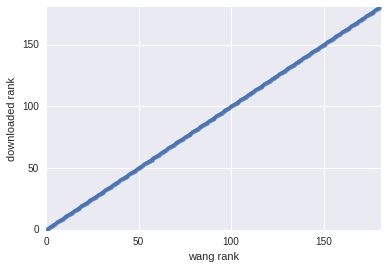

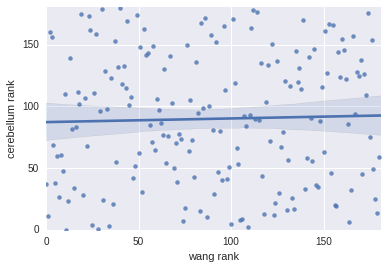

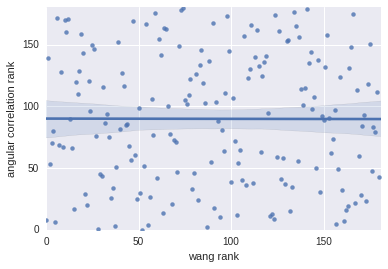

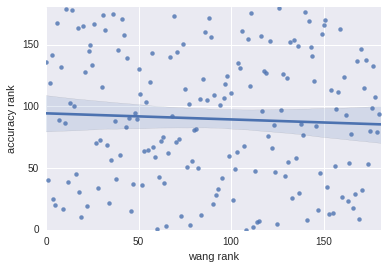

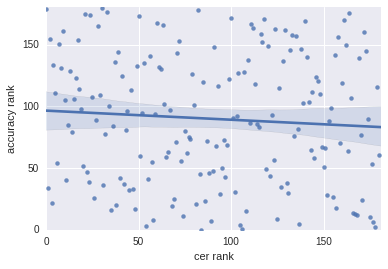

In [158]:
best_subjects_wang = determine_best_subjects(method = 'wang_all',n=181)

# check with existing ranks:
ranks = np.ravel(pd.read_csv(os.path.join(out_dir,'subjectrank.csv'))).astype(int)[::-1]-1
print 'correlation between own wang ranks and downloaded ranks:'
print sp.stats.spearmanr(ranks,best_subjects_wang)

pl.figure()
sn.regplot(best_subjects_wang,ranks)
pl.xlim(0,181)
pl.ylim(0,181)
pl.xlabel('wang rank')
pl.ylabel('downloaded rank')

# now compute best subjects from cerebellum ROIs
best_subjects_cer = determine_best_subjects(method = 'cerebellum_rois',n=181)

print 'correlation between cerebellum and wang rank:'
print sp.stats.spearmanr(best_subjects_wang,best_subjects_cer)

pl.figure()
sn.regplot(best_subjects_wang,best_subjects_cer)
pl.xlim(0,181)
pl.ylim(0,181)
pl.xlabel('wang rank')
pl.ylabel('cerebellum rank')


# now compute best subjects from cerebellum ROIs
best_subjects_ang = determine_best_subjects(method = 'angular_correlation',n=181)

print 'correlation between angular correaltion and wang rank:'
print sp.stats.spearmanr(best_subjects_wang,best_subjects_ang)

pl.figure()
sn.regplot(best_subjects_wang,best_subjects_ang)
pl.xlim(0,181)
pl.ylim(0,181)
pl.xlabel('wang rank')
pl.ylabel('angular correlation rank')

import pandas as pd
acc = np.ravel(pd.read_csv(os.path.join(out_dir,'behavior.csv')))
acc_rank = np.argsort(acc)[::-1]


print 'correlation between cerebellum rank and behavior rank:'
print sp.stats.spearmanr(best_subjects_cer,acc_rank)
print 'correlation between wang rank and behavior rank:'
print sp.stats.spearmanr(best_subjects_wang,acc_rank)

pl.figure()
sn.regplot(best_subjects_wang,acc_rank)
pl.xlim(0,181)
pl.ylim(0,181)
pl.xlabel('wang rank')
pl.ylabel('accuracy rank')

pl.figure()
sn.regplot(best_subjects_cer,acc_rank)
pl.xlim(0,181)
pl.ylim(0,181)
pl.xlabel('cer rank')
pl.ylabel('accuracy rank')





# mask voxels in different ways

In [53]:
def mask_voxels(data,mask_type,sj=None):
    """
    This function returns a mask bool where 
    1 = valid voxel
    0 = invalid voxel
    """
    
    if mask_type == 'none':
        """
        Simply a none mask
        """
        
        mask = np.ones_like(data).astype(bool)

    elif mask_type == 'r2':
        """
        this is the same mask as in the paper, 
        I've added the R2 for the weighted avg subject 
        by fitting a GMM to its r2s
        """
        
        # determine r2 threshold
        if sj in [181,182,183]:
            r2thresh=9.8
        elif sj == 184:
            r2thresh = 3.692
        elif sj == 185:
            r2thresh= 12.971
        else:
            r2thresh=2.2
        
        mask = (data[:,:,:,dims['r2']]>r2thresh)

    elif mask_type == 'r2_ecc':
        """
        This mask assumes there's two pools of voxels.
        The first is a pool of voxels that like the fovea
        and have no general interest for anything in the periphery.
        The logic here is that these voxels activate for 
        the increased difficulty when the bar passed fixation.
        """        
 
        # mask r2s with cerebellum mask:
        if sj in [181,182,183]:
            r2thresh=9.8
        elif sj == 184:
            r2thresh = 3.692  
        elif sj == 185:
            r2thresh= 12.971            
        else:
            r2thresh=2.2
            
        # mask voxels with ecc < 0.1 degrees of visual angle
        eccthresh=0.1   
    
        # define masks
        r2mask = (data[:,:,:,dims['r2']]>r2thresh) # valid voxels
        eccmask = (data[:,:,:,dims['ecc']]>eccthresh) # valid voxels

        # now combine r2 and ecc mask with the spillovermask
        mask = r2mask*eccmask
        
#     elif mask_type == 'r2_eccgmm':
#         """
#         This mask assumes there's two pools of voxels.
#         The first is a pool of voxels that like the fovea
#         and have no general interest for anything in the periphery.
#         The logic here is that these voxels activate for 
#         the increased difficulty when the bar passed fixation.
#         """        
 
#         # mask r2s with cerebellum mask:
#         if sj in [181,182,183]:
#             r2thresh=9.8
#         elif sj == 184:
#             r2thresh = 3.692            
#         else:
#             r2thresh=2.2

#         eccthresh = gmm_threshold(np.ravel(data[:,:,:,dims['ecc']]),n_components=2,maxrange=12)
#         print eccthresh
    
#         # define masks
#         r2mask = (data[:,:,:,dims['r2']]>r2thresh) # valid voxels
#         eccmask = (data[:,:,:,dims['ecc']]>eccthresh) # valid voxels

#         # now combine r2 and ecc mask with the spillovermask
#         mask = r2mask*eccmask
        
    elif mask_type == 'r2_spill':
        """
        This applies the spill mask drawn on data from the avg subject.
        The 'spill' refers to activity from cortex that is averaged
        into the cerebellum by the smoothing and nonlinear transformations
        to MNI space.
        """                
        
        # determine r2 threshold
        if sj in [181,182,183]:
            r2thresh=9.8
        elif sj == 184:
            r2thresh = 3.692
        elif sj == 185:
            r2thresh= 12.971            
        else:
            r2thresh=2.2

        r2mask = (data[:,:,:,dims['r2']]>r2thresh) 
        
        # load the spillover mask results nifti
        fn = os.path.join(out_dir,'masks','spillovermask.nii.gz')
        img = nb.load(fn)
        spillmask = img.get_data()
 
        # now combine r2 and ecc mask with the spillovermask
        mask = r2mask*(spillmask==0) # spillovermask is 0 for valid voxels
        
    elif mask_type == 'r2_spill_ecc':
        """
        This mask combines the spill and ecc masks
        """
        
        # load the spillover mask results nifti
        fn = os.path.join(out_dir,'masks','spillovermask.nii.gz')
        img = nb.load(fn)
        spillmask = img.get_data()
 
        # mask r2s with cerebellum mask:
        if sj in [181,182,183]:
            r2thresh=9.8
        elif sj == 184:
            r2thresh = 3.692  
        elif sj == 185:
            r2thresh= 12.971            
        else:
            r2thresh=2.2

        # mask voxels with ecc < 0.5
        eccthresh=0.1   
    
        # define masks
        r2mask = (data[:,:,:,dims['r2']]>r2thresh) # valid voxels
        eccmask = (data[:,:,:,dims['ecc']]>eccthresh) # valid voxels

        # now combine r2 and ecc mask with the spillovermask
        mask = r2mask*eccmask*(spillmask==0) # spillovermask is 0 for valid voxels
        
#     elif mask_type == 'r2_spill_ecc':
#         """
#         This mask combines the spill and GMM ecc masks
#         """
        
#         # load the spillover mask results nifti
#         fn = os.path.join(out_dir,'masks','spillovermask.nii.gz')
#         img = nb.load(fn)
#         spillmask = img.get_data()
 
#         # mask r2s with cerebellum mask:
#         if sj in [181,182,183]:
#             r2thresh=9.8
#         elif sj == 184:
#             r2thrsh = 12.971            
#         else:
#             r2thresh=2.2

#         # determine threshold using GMM
#         eccthresh = gmm_threshold(np.ravel(data[:,:,:,dims['ecc']]),n_components=2,maxrange=12)

#         # define masks
#         r2mask = (data[:,:,:,dims['r2']]>r2thresh) # valid voxels
#         eccmask = (data[:,:,:,dims['ecc']]>eccthresh) # valid voxels

#         # now combine r2 and ecc mask with the spillovermask
#         mask = r2mask*eccmask*(spillmask==0) # spillovermask is 0 for valid voxels
        
    elif mask_type == 'r2_spill_size':
        
        # load the spillover mask results nifti
        fn = os.path.join(out_dir,'masks','spillovermask.nii.gz')
        img = nb.load(fn)
        spillmask = img.get_data()
 
        # mask r2s with cerebellum mask:
        if sj in [181,182,183]:
            r2thresh=9.8
        elif sj == 184:
            r2thresh = 3.692
        elif sj == 185:
            r2thresh= 12.971            
        else:
            r2thresh=2.2

        # mask voxels with size < 0.15
        sizethresh=0.15
    
        # define masks
        r2mask = (data[:,:,:,dims['r2']]>r2thresh) # valid voxels
        sizemask = (data[:,:,:,dims['rfsize']]>sizethresh) # valid voxels

        # now combine r2 and ecc mask with the spillovermask
        mask = r2mask*sizemask*(spillmask==0) # spillovermask is 0 for valid voxels
        
    elif mask_type == 'r2_spill_fix':
        
        # load the spillover mask results nifti
        fn = os.path.join(out_dir,'masks','spillovermask.nii.gz')
        img = nb.load(fn)
        spillmask = img.get_data()
 
        # mask r2s with cerebellum mask:
        if sj in [181,182,183]:
            r2thresh=9.8
        elif sj == 184:
            r2thresh = 3.692
        elif sj == 185:
            r2thresh= 12.971            
        else:
            r2thresh=2.2

        # mask voxels with size < 0.15
        # let's assume that voxels with ecc < 0.15 (i.e. fixation size)
        # AND size of < 0.15 are voxels that respond to fixation dot.
        sizethresh=0.15
        eccthresh = 0.15
        sizemask = (data[:,:,:,dims['rfsize']]<sizethresh) # invalid voxels
        eccmask = (data[:,:,:,dims['ecc']]<eccthresh) # invalid voxels
        fixmask = np.invert(sizemask*eccmask) # valid voxels

        # define masks
        r2mask = (data[:,:,:,dims['r2']]>r2thresh) # valid voxels

        # now combine r2 and ecc mask with the spillovermask
        mask = r2mask*fixmask*(spillmask==0) # spillovermask is 0 for valid voxels
                
    elif mask_type == 'r2_roi':
        
        roi_fn = os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')
        maskimg = nb.load(roi_fn)
        roimask = (maskimg.get_data()>0)        
        
        # create r2 mask
        if sj in [181,182,183]:
            r2thresh=9.8
        elif sj == 184:
            r2thresh = 3.692
        elif sj == 185:
            r2thresh= 12.971            
        else:
            r2thresh=2.2
        r2mask = (data[:,:,:,dims['r2']]>r2thresh) # valid voxels

        mask = r2mask*roimask
        
#     elif mask_type == 'r2_buck':
        
#         # load cerebellum_mask from the cerebellum atlas to get the shape info
#         fn = os.path.join(out_dir,'buckner_dorsal_att.nii.gz')
#         img = nb.load(fn)
#         roimask = img.get_data().astype(bool)
        
#         # create r2 mask
#         if sj in [181,182,183]:
#             r2thresh=9.8
        
#         elif sj == 184:
#             r2thrsh = 3.692
#         else:
#             r2thresh=2.2
#         r2mask = (data[:,:,:,dims['r2']]>r2thresh) # valid voxels

#         mask = r2mask*roimask        
 
#     elif mask_type == 'gmmr2_roi':
        
#         # load cerebellum_mask from the cerebellum atlas to get the shape info
#         fncer = '/home/vanes/bin/fsl/data/atlases/Cerebellum/Cerebellum-MNIfnirt-maxprob-thr50-2mm.nii.gz'
#         cerimg = nb.load(fncer)
#         roimask = np.zeros(cerimg.shape)
        
#         # now create roi mask out of selected rois:
#         rois = ['left_ventral','right_ventral']#,'left_central','right_central']
#         for roi in rois:
#             roi_fn = os.path.join(out_dir,roi+'.nii.gz')
#             roiimg = nb.load(roi_fn)
#             roidata = roiimg.get_data() 
#             roimask[roidata==1] = 1
#         roimask = (roimask == 1) # these are the valid voxels
        
#         # use r2s from whole brain
#         r2s = np.ravel(allresults[0,sj,dims['r2'],:])
#         r2thresh = gmm_threshold(r2s)
# #         r2thresh = gmm_threshold(np.ravel(data[:,:,:,dims['r2']]))
#         print r2thresh
#         r2mask = (data[:,:,:,dims['r2']]>r2thresh) # valid voxels

#         mask = r2mask*roimask
        
    return mask


### now that we have the best subjects, let's create a 'best_subjects' folder with differently masked niftis in there

Let's do masking as follows:

1. as in paper: r_squared for the avg subjects at 9.8, for the individual subjects at 2.2
2. same r2 mask as in paper, but also include ecc mask > 0.5 dva

In [152]:
best_subjects = determine_best_subjects(method = 'angular_corr',n=181)
order = [np.where(best_subjects==s)[0][0] for s in range(181)]

for sj in np.arange(181):#np.hstack([[183,184],best_subjects]):#np.hstack([range(181),183]):
    
    print('now creating masked niftis for subject %d'%sj)

    if sj == 183:
        mask_types =  ['r2','r2_spill','r2_spill_fix','r2_roi']#,'r2_spill_size','r2_roi']#'r2_ecc']#['r2','r2_spill','r2_spill_ecc','r2high_spill','r2_buck']
        rank = 'avg'
    elif sj == 184:
        rank = 'wavg'
        mask_types = ['r2','r2_spill','r2_spill_fix','r2_roi']
    elif sj == 185:
        rank = 'wavgmask'
        mask_types = ['r2','r2_spill','r2_spill_fix','r2_roi']        
    else:
        mask_types = ['r2_roi']#,'r2_spill_fix']#['r2_roi']
        rank = str(np.where(best_subjects==sj)[0][0])
        
    for mask_type in mask_types:
    
        # try to create mask dir
        mask_dir = os.path.join(out_dir,'masked_niftis',mask_type)
        if not os.path.isdir(mask_dir): os.mkdir(mask_dir)

        # load the prf results nifti
        fn = os.path.join(out_dir,'all_subjects','prfresults_subject_%s.dscalar_data_sub.nii'%sj)        
        img = nb.load(fn)
        data = img.get_data()

        # determine the mask
        mask = mask_voxels(data,mask_type,sj)
        
        #mask data
        data[~mask] = np.nan
        

        # save datae
        out_fn = os.path.join(mask_dir,'prfresults_subject_rank_%s.nii'%rank)        
        new_data = nb.Nifti1Image(data,affine=img.affine,header=img.header)
        nb.save(new_data,out_fn[:-4])

        # save dimensions separately (for surface plots)
        for m in ['ang','ecc','rfsize','r2']:#,'dist','instim']:
            these_data = data[:,:,:,dims[m]]
            if m == 'ang':
                these_data = np.radians(these_data)
            out_fn = os.path.join(mask_dir,'prfresults_subject_rank_%s_%s.nii'%(rank,m))        
            new_data = nb.Nifti1Image(these_data,affine=img.affine,header=img.header)
            nb.save(new_data,out_fn[:-4])    



now creating masked niftis for subject 0
now creating masked niftis for subject 1
now creating masked niftis for subject 2
now creating masked niftis for subject 3
now creating masked niftis for subject 4
now creating masked niftis for subject 5
now creating masked niftis for subject 6
now creating masked niftis for subject 7
now creating masked niftis for subject 8
now creating masked niftis for subject 9
now creating masked niftis for subject 10
now creating masked niftis for subject 11
now creating masked niftis for subject 12
now creating masked niftis for subject 13
now creating masked niftis for subject 14
now creating masked niftis for subject 15
now creating masked niftis for subject 16
now creating masked niftis for subject 17
now creating masked niftis for subject 18
now creating masked niftis for subject 19
now creating masked niftis for subject 20
now creating masked niftis for subject 21
now creating masked niftis for subject 22
now creating masked niftis for subject 23
no